In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import mysql.connector
import pickle
import math
import operator
import random
from sqlalchemy import create_engine

In [10]:
class distancias:

    def __init__(self):
        
        pass

    def distancia_euclidiana(self, vector1, vector2):

        self.vectorA, self.vectorB = vector1, vector2

        if len(self.vectorA) != len(self.vectorB):
            raise ValueError("Vectores deben ser de la misma longitud")
        distance = 0.0

        for i in range(len(self.vectorA) - 1):
            distance += (self.vectorA[i] - self.vectorB[i])**2
        return (distance)**0.5
    
    def distancia_manhattan(self, vector1, vector2):

        self.vectorA, self.vectorB = vector1, vector2

        if len(self.vectorA) != len(self.vectorB):
            raise ValueError("Vectores deben ser de la misma longitud")
        return np.abs(np.array(self.vectorA) - np.array(self.vectorB)).sum()
    
    def distancia_hamming(self, vector1, vector2):

        self.vectorA, self.vectorB = vector1, vector2

        if len(self.vectorA) != len(self.vectorB):
            raise ValueError("Vectores deben ser de la misma longitud")
        return sum(el1 != el2 for el1, el2 in zip(self.vectorA, self.vectorB))

In [11]:
class KNN:

    def __init__(self, k = 3, distanciaM = 'euclidiana'):

        pass

    def fit(self, xTrain, yTrain):

        assert len(xTrain) == len(yTrain)
        self.trainData = xTrain
        self.trainLabels = yTrain

    def getNeighbors(self, testRow):

        cDistancia = distancias()
        distancia = []

        for i, trainRow in enumerate(self.trainData):
            if self.distanciaM == 'euclidiana':
                distancia.append([trainRow, cDistancia.distancia_euclidiana(testRow, trainRow), self.trainLabels[i]])
            elif self.distanciaM == 'manhattan':
                distancia.append([trainRow, cDistancia.distancia_euclidiana(testRow, trainRow), self.trainLabels[i]])
            elif self.distanciaM == 'hamming':
                distancia.append([trainRow, cDistancia.distancia_euclidiana(testRow, trainRow), self.trainLabels[i]])
            distancia.sort(key=operator.itemgetter(1))

        neighbors = []

        for index in range(self.k):
            neighbors.append(distancia[index])
        return neighbors
    
    def prediccion(self, xTest, k, distanciaM):

        self.testData = xTest
        self.k = k
        self.distanciaM = distanciaM
        predicciones = []

        for i, testCase in enumerate(self.testData):
            neighbors = self.getNeighbors(testCase)
            salida = [row[-1] for row in neighbors]
            prediccion = max(set(salida), key=salida.count)
            predicciones.append(prediccion)

        return predicciones


In [12]:
def printMetricas(actual, predictions):
    assert len(actual) == len(predictions)
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predictions[i]:
            correct += 1
    return (correct / float(len(actual)) * 100.0)

In [13]:
class kFold:

    def __init__(self):

        pass

    def Validacion_Cross(self, dataset, nFolds):

        dataSplit = list()
        dataC = list(dataset)
        tFold = int(len(dataset) / nFolds)

        for _ in range(nFolds):
            fold = list()
            while len(fold) < tFold:
                index = random.randrange(len(dataC))
                fold.append(dataC.pop(index))
            dataSplit.append(fold)
        return dataSplit
    
    def kfc_evaluacion(self, dataset, nFolds, *args):
        knn = KNN()
        folds = self.Validacion_Cross(dataset, nFolds)
        puntuaciones = list()

        for i in range(nFolds):
            trainSet = [f for j, f in enumerate(folds) if j != i]  # Todos los folds excepto el i-ésimo
            trainSet = sum(trainSet, [])
            testSet = folds[i]  # El i-ésimo fold es el conjunto de prueba
            
            trainLabels = [row[-1] for row in trainSet]
            trainSet = [train[:-1] for train in trainSet]  # Asegúrate de eliminar la columna de etiquetas de trainSet
            knn.fit(trainSet, trainLabels)

            actual = [row[-1] for row in testSet]
            testSet = [test[:-1] for test in testSet]

            prediccion = knn.prediccion(testSet, *args)

            accuracy = printMetricas(actual, prediccion)
            puntuaciones.append(accuracy)

            print('*'*20)
            print('Scores: %s' % puntuaciones)
            print('*'*20)        
            print('\nMaximum Accuracy: %3f%%' % max(puntuaciones))
            print('\nMean Accuracy: %.3f%%' % (sum(puntuaciones)/float(len(puntuaciones))))



In [14]:
# Leer el archivo CSV
df = pd.read_csv('muestra_real.csv')

# La columna "Tipo de Archivo" es la etiqueta
trainLabels = df["Tipo de Archivo"].values

# El resto son las características
trainFeatures = df.drop("Tipo de Archivo", axis=1).values


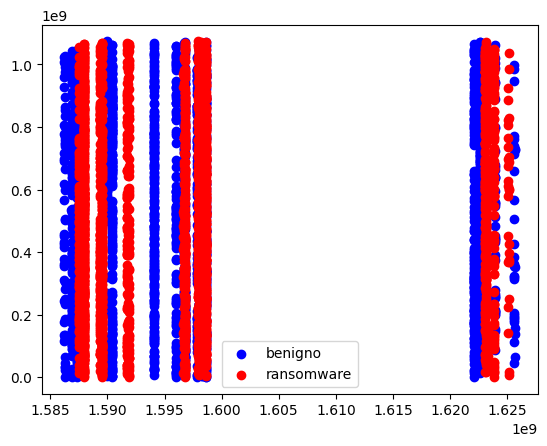

In [20]:
import matplotlib.pyplot as plt

# Supongamos que tienes tus características en una variable llamada features
# y tus etiquetas en una variable llamada labels

features_benigno = trainFeatures[trainLabels == 'benigno']
features_ransomware = trainFeatures[trainLabels == 'ransomware']

plt.scatter(features_benigno[:, 0], features_benigno[:, 1], color='b', label='benigno')
plt.scatter(features_ransomware[:, 0], features_ransomware[:, 1], color='r', label='ransomware')

plt.legend()
plt.show()


In [15]:
kfcv = kFold()

In [18]:
kfcv.kfc_evaluacion(trainFeatures, 3, 4, 'hamming')

********************
Scores: [7.44297719087635]
********************

Maximum Accuracy: 7.442977%

Mean Accuracy: 7.443%
********************
Scores: [7.44297719087635, 7.022809123649459]
********************

Maximum Accuracy: 7.442977%

Mean Accuracy: 7.233%
********************
Scores: [7.44297719087635, 7.022809123649459, 7.503001200480192]
********************

Maximum Accuracy: 7.503001%

Mean Accuracy: 7.323%


In [23]:
# Crear una cuadrícula de puntos para visualizar el espacio de decisión
x_min, x_max = trainFeatures[:, 0].min() - 1, trainFeatures[:, 0].max() + 1
y_min, y_max = trainFeatures[:, 1].min() - 1, trainFeatures[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1.0),  # Cambiar el paso a un valor más grande
                     np.arange(y_min, y_max, 1.0))  # Cambiar el paso a un valor más grande

# Predecir la etiqueta para cada punto en la cuadrícula
Z = kfcv.prediccion(np.c_[xx.ravel(), yy.ravel()], k=3, distanciaM='euclidiana')
Z = np.array(Z).reshape(xx.shape)

# Dibujar el espacio de decisión
plt.contourf(xx, yy, Z, alpha=0.8)

# Dibujar los puntos de datos
plt.scatter(trainFeatures[:, 0], trainFeatures[:, 1], c=trainLabels, edgecolor='k')

plt.show()
